# Artifact Removal and EEG Quality Index Assessment

This notebok requires the `.npz` files exported from the [Import datasets](./01_Import_datasets.ipynb) Notebook,
The pipeline of this notebooks is as follows:
1) The files are imported
2) A MNE Object is created for automatic eyeblink removal with [ICA](https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html#tut-artifact-ica)
3) The data is cleaned with the custom artifact removal tool
4) Raw and cleaned data (ICA, and custom script) are stored in `artifact_removal_results.npz`

In [3]:
#%% Import standard libraries
import os
import mne
import sys
import time
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib.collections as collections

#%% Import custom libraries
sys.path.append("..") # Adds higher directory to python modules path.
from Functions import artifact_removal_tools as art
from Functions import eeg_preprocessing
from Functions import eeg_quality_index
from IPython.display import clear_output

## Settings and data import


In [4]:
## Settings
save_data = True    # Enable to save raw and process data

## Import data
notebook_dir = os.getcwd()              # Notebook directory
os.chdir('..')                          # Move one folder up
main_dir = os.getcwd()                  # Main project directory
data_folder = main_dir + "\\Data"       # Data folder
all_files = os.listdir(path=data_folder)# List of subjects
os.chdir(notebook_dir)                  # Return to notebook directory

# - Select only .edf files and remove file extension
edf_files = [file.split('.')[0] for file in all_files if file.split('.')[-1] =='edf']

## Preallocate variables
n_files = len(edf_files)        # Number of files
clean_eeg = [None] * n_files    # Clean segment of EEG data [V] [n_channels x samples]
eye_eeg = [None] * n_files      # 
mus_eeg = [None] * n_files
srate = [None] * n_files
chans = [None] * n_files

## Select valid EEG channels
# - List of valid EEG channels to separate them from other types of data
eeg_valid_chans = np.array(['FP1','FP2','F3','F4','C3','C4','P3','P4','O1','O2','F7','F8',
                    'T3','T4','T5','T6','T1','T2','FZ','CZ','PZ'])

# - Select only the valid channels from each file
for f,file in enumerate(edf_files):
    # Load temporary data
    temp_file_name = data_folder + '\\' + file + '.npz'
    temp_data = np.load(temp_file_name, allow_pickle=True)
    
    # Get index of valid EEG channels
    chans[f] = temp_data['chans']   # List of all channels
    eeg_idx = np.zeros(np.size(eeg_valid_chans), dtype=int) # Temporary index for channels
    print(f'{file} file loaded')

    for ci,c in enumerate(eeg_valid_chans): # For channel_index in channel
        if np.size(np.where(chans[f]==c)) > 0:
            eeg_idx[ci] = (np.where(chans[f]==c)[0])

    eeg_idx = np.sort(eeg_idx)      # Sort list of channels
    chans[f] = chans[f][eeg_idx]    # Select only valid channels
    
    # Organize eye and muscle artifacts in tensors
    eye_artifacts = np.size(temp_data['eye_eeg'])
    eye_eeg[f] = [None] * eye_artifacts
    for eye in range(eye_artifacts):
        eye_eeg[f][eye] = temp_data['eye_eeg'][eye][eeg_idx,:]

    mus_artifacts = np.size(temp_data['mus_eeg'])
    mus_eeg[f] = [None] * mus_artifacts
    for mus in range(mus_artifacts):
        mus_eeg[f][mus] = temp_data['mus_eeg'][mus][eeg_idx,:]

    # Separate clean EEG and sampling rate
    clean_eeg[f] = temp_data['clean_eeg'][eeg_idx,:]    
    srate[f] = temp_data['srate']
    
    del temp_data   # Delete temporary data from memory


00000254_s007_t000 file loaded
00000647_s002_t000 file loaded
00000768_s003_t000 file loaded


## Preprocessing


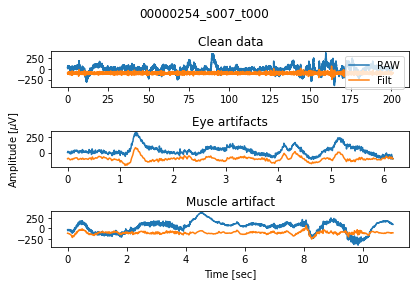

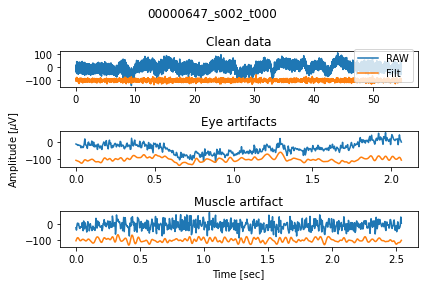

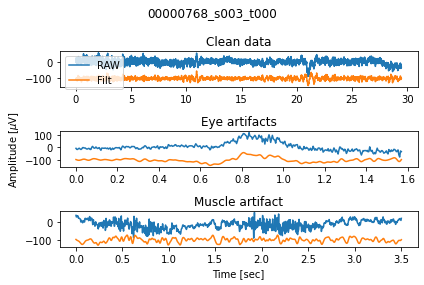

In [30]:
#%% Preallocate data
clean_pre_eeg = [None] * n_files
mus_pre_eeg =   [None] * n_files
eye_pre_eeg =   [None] * n_files # Preallocate data

#%% Settings
plot_filtered = True
scale = 1e6
offset = 100

fc = [1, 30]    # Cut-off frequencies [Hz]
f_type = "band" # Filter type
f_order = 4     # Filter order [n]

#%% Filter data
for f,file in enumerate(edf_files):
    clean_pre_eeg[f] = eeg_preprocessing.filter(f_type, clean_eeg[f], fc=fc, srate=int(srate[f]), order=f_order)

    artifacts = len(eye_eeg[f])
    eye_pre_eeg[f] = [None] * artifacts
    for a in range(artifacts):
        eye_pre_eeg[f][a] = eeg_preprocessing.filter(f_type, eye_eeg[f][a], fc=fc, srate=int(srate[f]), order=f_order)

    artifacts = len(mus_eeg[f])
    mus_pre_eeg[f] = [None] * artifacts
    for a in range(artifacts):
        mus_pre_eeg[f][a] = eeg_preprocessing.filter(f_type, mus_eeg[f][a], fc=fc, srate=int(srate[f]), order=f_order)

    if plot_filtered:
        fig, ax = plt.subplots(3,1)
        plt.suptitle(f"{file}")

        ax[0].set_title("Clean data")
        temp_time = np.linspace(0, np.max(np.shape(clean_eeg[f]))/srate[f], np.max(np.shape(clean_eeg[f])))
        ax[0].plot(temp_time, scale*clean_eeg[f][0,:], label="RAW")
        ax[0].plot(temp_time, scale*clean_pre_eeg[f][0,:] - offset, label="Filt")
        ax[0].legend()

        ax[1].set_title("Eye artifacts")
        temp_time = np.linspace(0, np.max(np.shape(eye_eeg[f][0]))/srate[f], np.max(np.shape(eye_eeg[f][0])))
        ax[1].plot(temp_time, scale*eye_eeg[f][0][0,:], label="RAW")
        ax[1].plot(temp_time, scale*eye_pre_eeg[f][0][0,:] - offset, label="Filt")
        ax[1].set_ylabel("Amplitude [$\mu$V]")

        ax[2].set_title("Muscle artifact")
        temp_time = np.linspace(0, np.max(np.shape(mus_eeg[f][0]))/srate[f], np.max(np.shape(mus_eeg[f][0])))
        ax[2].plot(temp_time, scale*mus_eeg[f][0][0,:], label="RAW")
        ax[2].plot(temp_time, scale*mus_pre_eeg[f][0][0,:] - offset, label="Filt")
        ax[2].set_xlabel("Time [sec]")

    plt.tight_layout()
    del temp_time, artifacts

## Artifact removal tool settings

Change the settings below for the artifact removal tool of eye blink and muscle artifacts

In [11]:
window_length = 0.9 # Window length for embedding matrix [sec]
n_clusters = 10     # Number of clusters for kmean classification [n]

## Eye movement artifacts

### Clean eye movement

Clean eye movement with the artifact removal tool as well as with automated [MNE ICA removal]()

In [22]:
eye_clean = [None] * n_files    # Preallocate eye artifact clean
artifacts = 3

for i in range(artifacts):
    eye_clean[i] = [None] * artifacts

    for a in range(artifacts):
        [eye_clean[i][a],_,_] = art.remove_eyeblinks_cpu(eye_pre_eeg[i][a], srate=srate[i], window_length=window_length, n_clusters=n_clusters)

### Plot eye movement - raw and cleaned

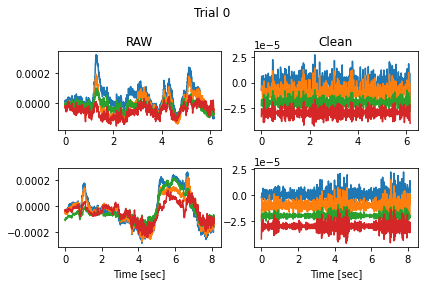

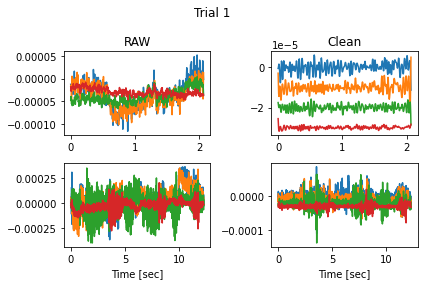

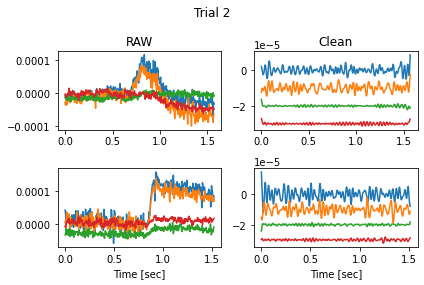

In [17]:
trials = [0,1,2]
artifacts = [0,2]
channels = [3,6,7,13]
offset = 1e-5
for t in trials:
    fig, ax = plt.subplots(len(artifacts),2)
    fig.suptitle(f'Trial {t}')
    for a in range(len(artifacts)):
        ax[0][0].set_title('RAW')
        ax[0][1].set_title('Clean')
        ax[len(artifacts)-1][0].set_xlabel('Time [sec]')
        ax[len(artifacts)-1][1].set_xlabel('Time [sec]')
        for c in range(len(channels)):
            time_vect = np.linspace(0, np.size(eye_eeg[t][a],1)/srate[t], np.size(eye_eeg[t][a],1))
            ax[a][0].plot(time_vect, eye_eeg[t][a][c,:] - c*offset)
            ax[a][1].plot(time_vect, eye_clean[t][a][c,:]- c*offset)
    plt.tight_layout()


## Muscle artifacts

## Clean muscle artifacts

In [30]:
mus_clean = [None] * n_files    # Preallocate eye artifact clean
artifacts = 3

for f in range(n_files):
    mus_clean[f] = [None] * artifacts

    for a in range(artifacts):
        temp_emg = eeg_preprocessing.filter('band', mus_eeg[f][a], fc=[1,30], srate=int(srate[f]), order=10)
        [mus_clean[f][a],_,_] = art.remove_eyeblinks_cpu(temp_emg, srate=srate[f], window_length=window_length, n_clusters=n_clusters)

### Plot muscle artifacts

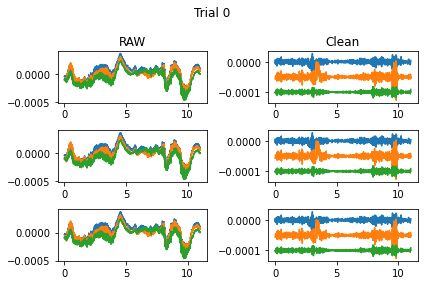

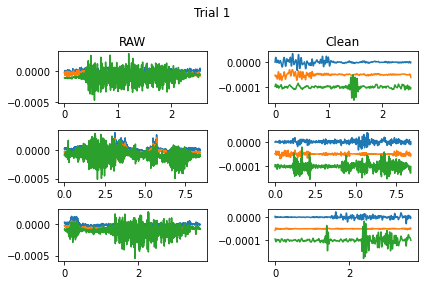

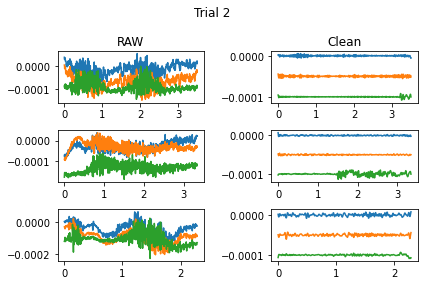

In [32]:
# Settings 
plot_muscle = True # Enable to plot clean trials and muscle artifacts
trials = [0,1,2]    # List of trials to plot
artifacts = [0,1,2] # List of artifacts per trial to plot
channels = [0,1,2]  # List of channels to plot
offset = 5e-5      # Offset per channel for easier visualization [V]

if plot_muscle:
    for t in trials:
        fig, ax = plt.subplots(len(artifacts),2)
        fig.suptitle(f'Trial {t}')
        ax[0][0].set_title('RAW')
        ax[0][1].set_title('Clean')

        for a in range(len(artifacts)):    
            for c in range(len(channels)):
                time_vect = np.linspace(0, np.size(mus_eeg[t][a],1)/srate[t], np.size(mus_eeg[t][a],1))
                ax[a][0].plot(time_vect, mus_eeg[t][a][c,:] - c*offset)
                ax[a][1].plot(time_vect, mus_clean[t][a][c,:]- c*offset)
        plt.tight_layout()

## Calculate EEG Quality Index

### Eye artifacts quality index

In [33]:
sfreq = int(srate[0])
[ct_eye_raw,_,eqi_eye_raw] = eeg_quality_index.scoring(clean_eeg[0], eye_eeg[0][2], sfreq, sfreq, window=sfreq, slide=1)
[ct_eye_art,_,eqi_eye_art] = eeg_quality_index.scoring(clean_eeg[0], eye_clean[0][2], sfreq, sfreq, window=sfreq, slide=1)

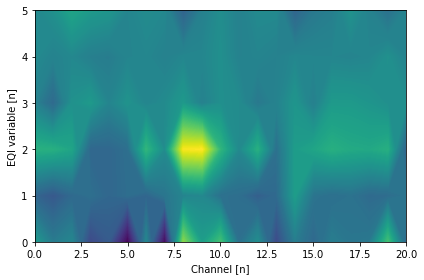

In [18]:
clean_table = np.array([ct_eye_raw, ct_eye_art]).T
eqi_diff = eqi_eye_raw - eqi_eye_art

x = np.arange(np.size(eqi_diff,0))
y = np.arange(np.size(eqi_diff,1))
fig, ax = plt.subplots()
cs = ax.contourf(eqi_diff, levels=200)
ax.set_ylabel('EQI variable [n]')
ax.set_xlabel('Channel [n]')
plt.tight_layout()

### Muscle artifacts quality index

## Save data

Save data to NPZ file for further analysis

In [ ]:
save_file = f'art_w{window_length}_k{n_clusters}'

if save_data:
    np.savez(save_file, eye_raw=eye_eeg, mus_raw=mus_eeg, srate=srate, eye_clean=eye_clean, mus_clean=mus_clean)
    